### ARIMA


##### Importing libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller


##### importing the data 

In [2]:
df = pd.read_pickle("my_preprocessed_data.pkl")

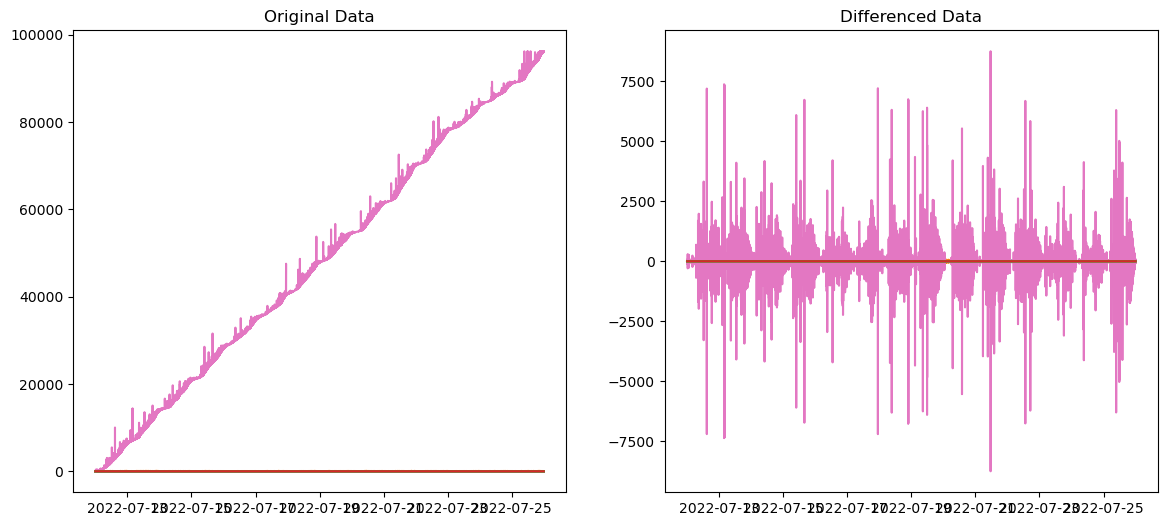

In [3]:

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(df)
plt.title('Original Data')
df_diff = df.diff().dropna()
plt.subplot(1, 2, 2)
plt.plot(df_diff)
plt.title('Differenced Data')

plt.show()


In [ ]:
column = 'Interruptions'
result = adfuller(df[column])
if result[1] > 0.05:
    df[column] = df[column].diff().dropna()
else:
    print('The data is already stationary')
train_data, test_data = train_test_split(df[[column]], test_size=0.2, shuffle=False)

In [ ]:
model = auto_arima(train_data, seasonal=True, m=12, suppress_warnings=True, stepwise=True)
model_fit = model.fit(train_data)

In [ ]:
forecast = model_fit.predict(n_periods=len(test_data))

In [64]:
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
r2 = r2_score(test_data, forecast)
print(f"Column: {column}")
print(f"Best model: {model_fit.summary()}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
residuals = np.array(test_data)[:, 0] - forecast
residuals_mean = residuals.mean()
residuals_std = residuals.std()
threshold = 2 * residuals_std
anomalies = residuals[(residuals > residuals_mean + threshold) | (residuals < residuals_mean - threshold)]
num_anomalies = len(anomalies)
print(f"Number of anomalies: {num_anomalies}")
print()

The data is already stationary
Column: Interruptions
Best model:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                16360
Model:                        SARIMAX   Log Likelihood              120461.321
Date:                Wed, 24 May 2023   AIC                        -240918.642
Time:                        18:33:08   BIC                        -240903.237
Sample:                             0   HQIC                       -240913.553
                              - 16360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.201e-05   2.16e-06      5.570      0.000    7.78e-06    1.62e-05
sigma2      2.355e-08   8.49e-12   2773.007      0.000    2.35e-08

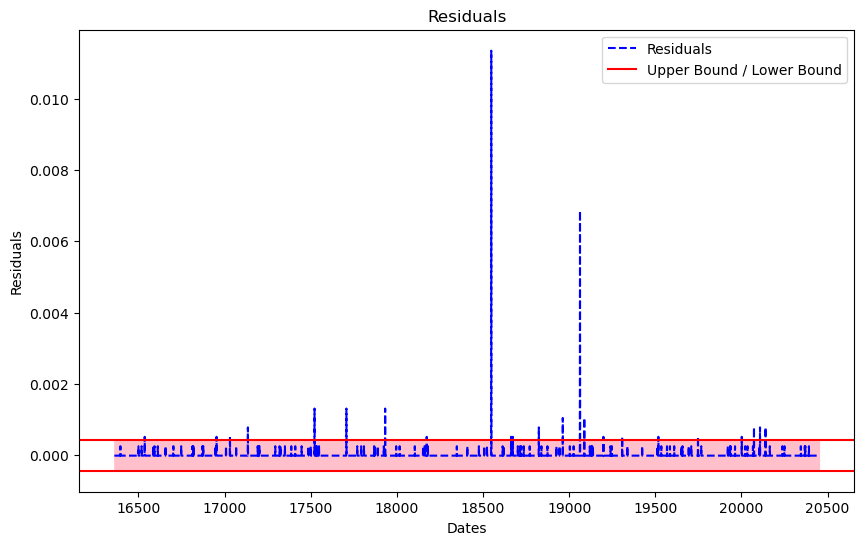

In [66]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index, residuals, color='blue', linestyle='dashed', 
         label='Residuals')
plt.axhline(y=residuals_mean + threshold, color='r', linestyle='-', label='Upper Bound / Lower Bound')
plt.axhline(y=residuals_mean - threshold, color='r', linestyle='-')
plt.fill_between(test_data.index, residuals_mean - threshold, residuals_mean + threshold, color='pink')
plt.title('Residuals')
plt.xlabel('Dates')
plt.ylabel('Residuals')
plt.legend()
plt.show()

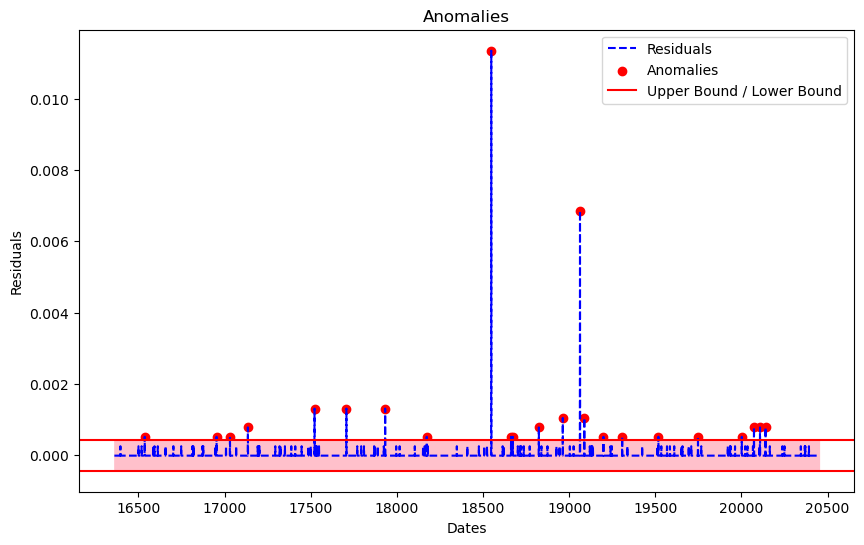

In [68]:
anomalies_df = pd.DataFrame(index=test_data.index)
anomalies_df['anomalies'] = np.where((residuals > residuals_mean + threshold) | (residuals < residuals_mean - threshold), residuals, np.nan)
plt.figure(figsize=(10,6))
plt.plot(test_data.index, residuals, color='blue', linestyle='dashed', label='Residuals')
plt.scatter(anomalies_df.index, anomalies_df['anomalies'], color='red', label='Anomalies')
plt.axhline(y=residuals_mean + threshold, color='r', linestyle='-', label='Upper Bound / Lower Bound')
plt.axhline(y=residuals_mean - threshold, color='r', linestyle='-')
plt.fill_between(test_data.index, residuals_mean - threshold, residuals_mean + threshold, color='pink')
plt.title('Anomalies')
plt.xlabel('Dates')
plt.ylabel('Residuals')
plt.legend()
plt.show()